### The model is trained with the activation function "SELU". By default, the other models are trained with "GELU"

In [ ]:
import pandas as pd

In [ ]:
exp1 = pd.read_csv("Data/exp1.csv")
exp1 = exp1.drop("Unnamed: 0", axis=1)
exp2 = pd.read_csv("Data/exp2.csv")
exp2 = exp2.drop("Unnamed: 0", axis=1)

/tmp/ipykernel_1685278/1566420057.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  exp1 = pd.read_csv("Data/exp1.csv")
/tmp/ipykernel_1685278/1566420057.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  exp2 = pd.read_csv("Data/exp2.csv")


In [ ]:
exp1 = exp1.drop(["CellType", "Concentration","Replicate","Time", "Event","FSC-A","SSC-A"], axis=1)
exp2 = exp2.drop(["CellType","Replicate","Event","FSC-A","SSC-A"], axis=1)

In [ ]:
exp1 = exp1.fillna("null")
exp2 = exp2.fillna("null")

### Label encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

class CustomLabelEncoder(LabelEncoder):
    def __init__(self, custom_mapping=None, handle_unknown='ignore'):
        super().__init__()
        self.custom_mapping = custom_mapping
        self.handle_unknown = handle_unknown

    def fit(self, y):
        if self.custom_mapping:
            self.classes_ = np.array(list(self.custom_mapping.keys()))
            self.custom_mapping = {k: v for v, k in enumerate(self.classes_)}
        else:
            super().fit(y)
        return self

    def transform(self, y):
        if self.custom_mapping:
            return np.array([self.custom_mapping.get(item, -1 if self.handle_unknown == 'ignore' else self.custom_mapping[item]) for item in y])
        else:
            return super().transform(y)

    def fit_transform(self, y):
        return self.fit(y).transform(y)

    def inverse_transform(self, y):
        if self.custom_mapping:
            inverse_mapping = {v: k for k, v in self.custom_mapping.items()}
            return np.array([inverse_mapping.get(item, 'unknown' if self.handle_unknown == 'ignore' else inverse_mapping[item]) for item in y])
        else:
            return super().inverse_transform(y)

#labels = ['A2', 'E1', 'G4', 'N4', 'Q4', 'T4', 'V4', 'null']
custom_mapping = {'N4': 0, 'A2': 1, 'Q4': 2, 'T4':3, 'V4': 4, 'G4':5, 'E1':6, 'null':7 }

encoder = CustomLabelEncoder(custom_mapping=custom_mapping, handle_unknown='ignore')
exp1["Peptide"]=encoder.fit_transform(exp1["Peptide"])
exp2["Peptide"]=encoder.fit_transform(exp2["Peptide"])

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [ ]:
exp1.shape

(3042676, 25)

In [ ]:
exp1["Peptide"].value_counts()

Peptide
2    464938
3    446976
0    440901
1    397174
4    356661
7    353595
5    334790
6    247641
Name: count, dtype: int64

### Balancing the training dataset

In [ ]:
import numpy as np
import pandas as pd
from sklearn.utils import resample

min_class_count = exp1['Peptide'].value_counts().min()

downsampled_data = []

for label in exp1['Peptide'].unique():
    class_data = exp1[exp1['Peptide'] == label]
    downsampled_class_data = resample(class_data,
                                      replace=False,
                                      n_samples=min_class_count,
                                      random_state=42)
    downsampled_data.append(downsampled_class_data)

downsampled_data = pd.concat(downsampled_data)

print(downsampled_data['Peptide'].value_counts())
exp1 = downsampled_data
exp1["Peptide"].value_counts()

Peptide
0    247641
1    247641
2    247641
3    247641
4    247641
5    247641
6    247641
7    247641
Name: count, dtype: int64


Peptide
0    247641
1    247641
2    247641
3    247641
4    247641
5    247641
6    247641
7    247641
Name: count, dtype: int64

### Balancing the testing dataset

In [ ]:
import numpy as np
import pandas as pd
from sklearn.utils import resample

min_class_count = exp2['Peptide'].value_counts().min()

downsampled_data = []

for label in exp2['Peptide'].unique():
    class_data = exp2[exp2['Peptide'] == label]
    downsampled_class_data = resample(class_data,
                                      replace=False,
                                      n_samples=min_class_count,
                                      random_state=42)
    downsampled_data.append(downsampled_class_data)

downsampled_data = pd.concat(downsampled_data)

print(downsampled_data['Peptide'].value_counts())
exp2 = downsampled_data
exp2["Peptide"].value_counts()

Peptide
0    291473
1    291473
2    291473
3    291473
4    291473
5    291473
6    291473
7    291473
Name: count, dtype: int64


Peptide
0    291473
1    291473
2    291473
3    291473
4    291473
5    291473
6    291473
7    291473
Name: count, dtype: int64

### Scaling the training and testing datasets using MinMaxScaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

exp1_scaled = pd.DataFrame(scaler.fit_transform(exp1.drop(["Peptide"], axis=1)), columns=exp1.drop(["Peptide"], axis=1).columns)
exp1_scaled

exp2_scaled = pd.DataFrame(scaler.fit_transform(exp2.drop(["Peptide", "Concentration","Time"], axis=1)), columns=exp2.drop(["Peptide", "Concentration","Time"], axis=1).columns)
exp2_scaled

,CD25,CD38,Granzyme B,CD2,CD27,CD45RA,CD4,CD86,CXCR6,CD5,...,CD126,Proliferation,ICOS,IRF8,CD19,MHC-II,CD45,CD44,CX3CR1,CD8a
0,0.293692,0.310615,0.318449,0.349744,0.271750,0.349934,0.331325,0.255132,0.276637,0.478006,...,0.308943,0.506091,0.262262,0.300098,0.338147,0.335578,0.506586,0.317907,0.338727,0.495601
1,0.299897,0.321788,0.329025,0.318974,0.273705,0.414155,0.327711,0.296188,0.270772,0.615836,...,0.345528,0.120709,0.610611,0.248289,0.344164,0.126824,0.643364,0.318913,0.326861,0.652004
2,0.322647,0.279330,0.384254,0.251282,0.442815,0.397117,0.336145,0.257087,0.248289,0.546432,...,0.350610,0.799557,0.362362,0.333333,0.329723,0.277217,0.679838,0.228370,0.567422,0.475073
3,0.605998,0.277095,0.499412,0.502564,0.304008,0.511140,0.315663,0.290323,0.272727,0.571848,...,0.337398,0.524917,0.710711,0.342131,0.430806,0.023569,0.643364,0.249497,0.606257,0.637341
4,0.520165,0.300559,0.334900,0.339487,0.262952,0.349934,0.322892,0.280547,0.282502,0.443793,...,0.259146,0.283499,0.516517,0.287390,0.332130,0.429854,0.476190,0.325956,0.333333,0.496579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2331779,0.283351,0.308380,0.333725,0.243077,0.267840,0.401048,0.328916,0.268817,0.292278,0.408602,...,0.292683,0.799557,0.295295,0.275660,0.336943,0.285073,0.508612,0.266600,0.346278,0.314761
2331780,0.309204,0.282682,0.345476,0.295385,0.268817,0.366972,0.309639,0.256109,0.312805,0.365591,...,0.304878,0.799557,0.292292,0.276637,0.333333,0.261504,0.525836,0.260563,0.379720,0.292278
2331781,0.284385,0.319553,0.629847,0.214359,0.266862,0.348624,0.319277,0.280547,0.369501,0.150538,...,0.288618,0.755260,0.275275,0.439883,0.350181,0.308642,0.531915,0.280684,0.422869,0.305963
2331782,0.280248,0.316201,0.365452,0.365128,0.271750,0.372215,0.332530,0.264907,0.329423,0.388074,...,0.293699,0.756368,0.334334,0.277615,0.321300,0.299663,0.603850,0.302817,0.366775,0.558162


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input

2024-07-29 09:56:41.749025: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-29 09:56:41.756526: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 09:56:41.765622: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 09:56:41.765642: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-29 09:56:41.772293: I tensorflow/core/platform/cpu_feature_gua

### Training the autoencoder model

In [ ]:
input_dim = 24
latent_dim = 2

# ENCODER ARCHITECTURE
encoder_input = Input(shape=(input_dim,))
encoder = Sequential([
    Dense(32, activation='selu'),
    Dense(24, activation='selu'),
    Dense(12, activation='selu'),
    Dense(latent_dim, activation='selu')
])

#DECODER ARCHITECTURE
decoder = Sequential([
    Dense(12, activation='selu', input_shape=(latent_dim,)),
    Dense(24, activation='selu'),
    Dense(32, activation='selu'),
    Dense(input_dim, activation=None)
])

# TRAINING THE AUTOENCODER MODEL
encoded = encoder(encoder_input)
decoded = decoder(encoded)
autoencoder = Model(inputs=encoder_input, outputs=decoded)
autoencoder.compile(loss='mse', optimizer='adam')

autoencoder.fit(exp1_scaled, exp1_scaled, epochs=5, batch_size=32, verbose=1)

# RECONSTRUCTING THE TRAINING DATASET
reconstructed1 = autoencoder.predict(exp1_scaled)
reconstructed_df1 = pd.DataFrame(reconstructed1)
reconstructed_df1 = reconstructed_df1.rename(columns=dict(zip(reconstructed_df1.columns, exp1_scaled.columns)))
correlation1 = exp1_scaled.corrwith(reconstructed_df1)
print(correlation1)

#RECONSTRUCTING THE TESTING DATASET
reconstructed2 = autoencoder.predict(exp2_scaled)
reconstructed_df2 = pd.DataFrame(reconstructed2)
reconstructed_df2 = reconstructed_df2.rename(columns=dict(zip(reconstructed_df2.columns, exp2_scaled.columns)))
correlation2 = exp2_scaled.corrwith(reconstructed_df2)
print(correlation2)

# OBTAINING THE LATENT SPACE OF THE TESTING DATASET
encoder_model = Model(inputs=encoder_input, outputs=encoded)

latent_space = encoder_model.predict(exp2_scaled)
latent_df = pd.DataFrame(latent_space, columns=[f'latent_dim_{i+1}' for i in range(latent_dim)])

Epoch 1/5
61911/61911 ━━━━━━━━━━━━━━━━━━━━ 70s 1ms/step - loss: 0.0037
Epoch 2/5
61911/61911 ━━━━━━━━━━━━━━━━━━━━ 68s 1ms/step - loss: 0.0025
Epoch 3/5
61911/61911 ━━━━━━━━━━━━━━━━━━━━ 68s 1ms/step - loss: 0.0024
Epoch 4/5
61911/61911 ━━━━━━━━━━━━━━━━━━━━ 64s 1ms/step - loss: 0.0023
Epoch 5/5
61911/61911 ━━━━━━━━━━━━━━━━━━━━ 62s 993us/step - loss: 0.0023
61911/61911 ━━━━━━━━━━━━━━━━━━━━ 27s 442us/step
CD25             0.929058
CD38             0.362096
Granzyme B       0.715575
CD2              0.876574
CD27             0.938794
CD45RA           0.686935
CD4              0.361869
CD86             0.447849
CXCR6            0.793578
CD5              0.927354
CD62L            0.804045
OX40             0.696902
PD-L1            0.747921
TBet             0.753397
CD126            0.766337
Proliferation    0.917577
ICOS             0.872423
IRF8             0.797836
CD19             0.558605
MHC-II           0.819719
CD45             0.852803
CD44             0.882490
CX3CR1           0.7900

### Latent space of the test dataset at all concentrations and all timepoints

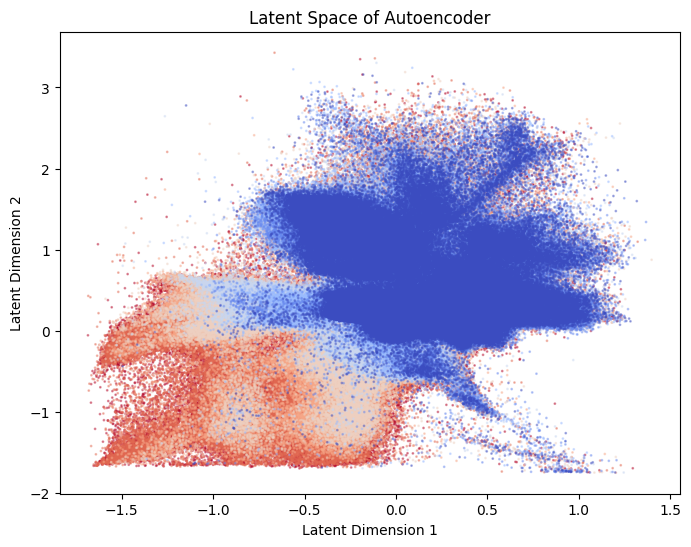

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf

cmap = plt.get_cmap('coolwarm')
reversed_cmap = cmap.reversed()
plt.figure(figsize=(8, 6))
plt.scatter(latent_df.iloc[:, 0], latent_df.iloc[:, 1], c=exp2["Peptide"], cmap=reversed_cmap, alpha=0.4, s=1)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space of Autoencoder')
plt.show()